In [263]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import missingno as msno

#Visualizations
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Text pre-processing and prediction
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, train_test_split

#NER
from transformers import AutoTokenizer, AutoModelForTokenClassification
import time
from sklearn.feature_extraction.text import CountVectorizer   
from transformers import pipeline

from guess_indian_gender import IndianGenderPredictor

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [93]:
data = pd.read_csv("project_memo2_cleanedv2.csv")
data.head()

,Unnamed: 0,Unnamed: 0.1,text,created_at,tweet_id,user_id,user_name,user_location,user_description,language,place
0,0,0,this is like worst nightmare to travel via thi...,Wed Nov 09 00:44:37 +0000 2022,1590143286739886081,1276462336631402497,Secular Bharat,NaN,।। मेरा भारत महान ।। सामाजिक कार्यकर्ता \n🇮🇳 ...,NaN,NaN
1,1,1,worst service by northern railways no indicato...,Wed Nov 09 00:43:00 +0000 2022,1590142877656842241,1291835304,Jaswant Yadav,"Mumbai, India",NaN,NaN,NaN
2,2,2,pnr 4759117458 i am not able to find any charg...,Wed Nov 09 00:42:58 +0000 2022,1590142869637320706,1240153396302184451,Gautam Juneja,NaN,||MBBS👨‍⚕️||JSSMC||\nLove to Travel ✈️✈️||,NaN,NaN
3,3,3,the picture of bangalore to nanded link expres...,Wed Nov 09 00:40:49 +0000 2022,1590142329062850561,1420717816676720645,Gulam Dastagir Shaik,NaN,Social worker,NaN,"{'id': '4f2838c764ad417c', 'url': 'https://api..."
4,4,4,sir i want to inform you that train no 05529 ...,Wed Nov 09 00:40:18 +0000 2022,1590142201824432133,2770364294,Trilok kumar,"New Delhi, India",Eveything is possible,NaN,NaN


In [94]:
data.shape

(18000, 11)

In [95]:
#Creating a field for train number 
re.findall(r"\b\d{5}\b", " This is the train number 01234 78903")[0]

'01234'

In [96]:
data['train_no'] =[re.findall(r"\b\d{5}\b", s)  for s in data['text']]

In [97]:
data['train_no'] = [ train[0] if train !=[] else 0 for train in data['train_no']]

In [50]:
train_no_frequency = data.groupby('train_no').count().reset_index()
train_no_frequency = train_no_frequency[['train_no', 'Unnamed: 0']]
train_no_frequency = train_no_frequency.sort_values('Unnamed: 0', ascending=False)

In [54]:
train_no_frequency[0:20]

,train_no,Unnamed: 0
0,0,12606
43,02563,42
73,03255,34
1031,15273,32
1027,15231,32
446,12262,30
1296,19490,29
45,02569,29
697,12772,25
543,12429,24


In [53]:
train_no_frequency.to_csv("train_number_frequency.csv")

In [60]:
tatkal_tweets = data[data['text'].str.contains("tatkal")].reset_index()

In [61]:
tatkal_trains = tatkal_tweets.groupby('train_no').count().reset_index()
tatkal_trains  = tatkal_trains [['train_no', 'Unnamed: 0']]
tatkal_trains = tatkal_trains.sort_values('Unnamed: 0', ascending=False)

In [79]:
tatkal_tweet_user_location = tatkal_tweets.groupby('user_location').count().reset_index()
tatkal_tweet_user_location = tatkal_tweet_user_location[['user_location','Unnamed: 0']]
tatkal_tweet_user_location = tatkal_tweet_user_location.sort_values('Unnamed: 0', ascending=False)
tatkal_tweet_user_location

,user_location,Unnamed: 0
29,"Mumbai, India",13
20,India,10
32,"New Delhi, India",6
18,"Hyderabad, India",5
14,"Gujarat, India",2
34,Prayagraj,2
30,Navi Mumbai,2
28,Mumbai,2
1,"Ajmer, India",2
38,"Thane, India",2


In [80]:
tatkal_tweet_user_location.to_csv('tatkal_tweet_user_location.csv')

In [43]:
data.text[0]

'this is like worst nightmare to travel via this train it s been 4 hours since i m on the station nd still railway staff are clueless of arrival of the train i just wann my train exact expected arrival time pls '

In [44]:
don_texts = data["text"][data['text'].str.contains("don")]

In [45]:
don_texts.to_csv("Texts_with_the_word_don.csv") #don actually is dont - so let's replace as it is one of the most common words

# Correcting Abbrevations which are important for sentiment analysis

In [46]:
data["text"] = [don.replace("don ", "dont ") for don in data['text']]

In [47]:
data["text"] = [don.replace("plz ", "please ") for don in data['text']]
data["text"] = [don.replace("pls ", "please ") for don in data['text']]
data["text"] = [don.replace("donno ", "dont know ") for don in data['text']]

# Default Sentiment Analysis

In [18]:
classifier = pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)


In [49]:
data['text'][38]

' pasanger complain put right by on board electric staff '

In [55]:
classifier(data['text'][38])

[{'label': 'NEGATIVE', 'score': 0.999133288860321}]

In [57]:
sentiments = [classifier(text) for text in data['text']]

In [66]:
pd.DataFrame(sentiments).to_csv("sentiments.csv")

In [68]:
sentiments[0][0]

{'label': 'NEGATIVE', 'score': 0.999583899974823}

In [69]:
text_label = [sentiment[0]['label'] for sentiment in sentiments]
text_score = [sentiment[0]['score'] for sentiment in sentiments]

In [72]:
data['sentiment_label']= text_label
data['sentiment_score']= text_score

### Remove duplicates based on the tweetid

In [75]:
data.drop_duplicates(subset=['tweet_id'], keep='first', inplace=True)

In [76]:
data.shape

(14999, 13)

### Sentiment Analysis Results analysis

In [92]:
sentiment_results = data[["tweet_id", "sentiment_label"]].groupby(["sentiment_label"]).count().reset_index()
sentiment_results

,sentiment_label,tweet_id
0,NEGATIVE,10504
1,POSITIVE,4495


In [104]:
sentiment_results['tweet_share'] = sentiment_results['tweet_id']*100/(10504+4495)

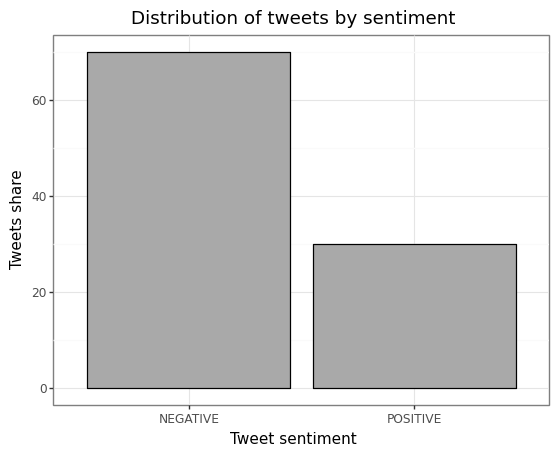

<ggplot: (167707446962)>

In [108]:
(
ggplot(sentiment_results, aes(x="sentiment_label", y="tweet_share"))+
geom_bar(fill='darkgray', color='black', stat='identity')+
labs(x="Tweet sentiment", y="Tweets share", title="Distribution of tweets by sentiment")+
theme_bw()
)

In [119]:
positive_sentiment = pd.DataFrame(data["text"][data['sentiment_label'] == "POSITIVE"]).reset_index()
positive_sentiment = positive_sentiment.drop("index", axis=1)
positive_sentiment.to_csv('positive_sentiment.csv')
positive_sentiment.head()

,text
0,the picture of bangalore to nanded link expres...
1,wah wah mast sarkaar hai aapki jaha complimen...
2,very nice
3,respected sir i am going to mathura through a...
4,somebody has stolen my shaul on gaya patna ra...


In [120]:
negative_sentiment = pd.DataFrame(data["text"][data['sentiment_label'] == "NEGATIVE"]).reset_index()
negative_sentiment = negative_sentiment.drop("index", axis=1)
negative_sentiment.to_csv('negative_sentiment.csv')
negative_sentiment.head()

,text
0,this is like worst nightmare to travel via thi...
1,worst service by northern railways no indicato...
2,pnr 4759117458 i am not able to find any charg...
3,sir i want to inform you that train no 05529 ...
4,sirpur khagaz to secunderabad bagyanagar expr...


In [133]:
data = data.reset_index()

In [136]:
data = data.drop(['index','Unnamed: 0', 'Unnamed: 0.1'],axis=1)

In [145]:
index = list(range(0,15000,1))
index[0:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [146]:
import random
random_index = random.sample(index,200)

In [148]:
len(random_index)

200

## Validating Sentiment Analysis results

In [151]:
Sent_Valid_Data = data.filter(items = random_index, axis=0)
Sent_Valid_Data = Sent_Valid_Data[['text', 'sentiment_label', "sentiment_score"]]
Sent_Valid_Data.shape

(200, 3)

In [152]:
Sent_Valid_Data.head()

,text,sentiment_label,sentiment_score
13135,traveling by bju ypr special train 05215 in 3...,NEGATIVE,0.971140
8546,reply from the service man was the we dont t ...,NEGATIVE,0.995413
9002,please look into the matter seriously take st...,POSITIVE,0.829115
5339,kindly look in to this matter,POSITIVE,0.999140
9774,ashwini vaishnaw train no 12398 new delhi to ...,NEGATIVE,0.996738


In [153]:
Sent_Valid_Data.to_csv("Sent_Valid_Data.csv")

# Name Entity Recognition

In [98]:
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
NER = pipeline("ner", model=model, tokenizer=tokenizer)

In [103]:
locations = []
for index, row in data.iterrows():
    
    NER_result = NER(row['text'])
    
    if bool(NER_result)==False:
        locations.append("")
        
    else:    
        df = pd.DataFrame(NER_result)
        df =df[df['entity']=="I-LOC"]
        df = df.sort_values('score', ascending=False).reset_index()
        location_entry = " ".join(df['word'])
        locations.append(location_entry)
        
data['locations'] =locations

In [104]:
set(locations)

{'',
 '##a',
 '##a ##a ##hian ##hian ##ud',
 '##a ##dar',
 '##a ##dh ##ud ##urg',
 '##a ##hian',
 '##a ##ka ##ta ##eral ##rna',
 '##a ##ore ##bat ##eral',
 '##a ##ud ##hian ##hang ##a',
 '##ab',
 '##ab ##ab',
 '##ab ##garh',
 '##aba ##aba ##la ##la',
 '##abad',
 '##abad ##abad',
 '##abad ##abad ##hi ##dham ##and ##med ##med',
 '##abad ##abad ##med',
 '##abad ##ala ##abad',
 '##abad ##ana',
 '##abad ##ganj ##s ##med',
 '##abad ##gu',
 '##abad ##hi',
 '##abad ##hp',
 '##abad ##i ##vat',
 '##abad ##med',
 '##abad ##med ##do',
 '##abad ##med ##hi',
 '##abad ##med ##na',
 '##abad ##med ##nagar ##hi',
 '##abad ##med ##pur',
 '##abad ##med ##wa',
 '##abad ##med ah ##pur',
 '##abad ##med ka',
 '##abad ##nagar ##med him ##pur',
 '##abad ##nagar him ##med',
 '##abad ##nai',
 '##abad ##nai ##med',
 '##abad ##pur',
 '##abad ##pur ##hp ##ur',
 '##abad ##pur ##med',
 '##abad ##pur ##med am',
 '##abad ##ur ##hp ##n ##pur',
 '##abad ##ya ##dh ##med',
 '##abad mum',
 '##abad se ##nder',
 '##ach ##ow',


# Gender Detection

In [158]:
gender_pred = IndianGenderPredictor()

In [17]:
gender_pred.predict(name="Samanta") # returns male

'female'

In [159]:
data.head()

,text,created_at,tweet_id,user_id,user_name,user_location,user_description,language,place,sentiment_label,sentiment_score,locations
0,this is like worst nightmare to travel via thi...,Wed Nov 09 00:44:37 +0000 2022,1590143286739886081,1276462336631402497,Secular Bharat,NaN,।। मेरा भारत महान ।। सामाजिक कार्यकर्ता \n🇮🇳 ...,NaN,NaN,NEGATIVE,0.999584,
1,worst service by northern railways no indicato...,Wed Nov 09 00:43:00 +0000 2022,1590142877656842241,1291835304,Jaswant Yadav,"Mumbai, India",NaN,NaN,NaN,NEGATIVE,0.999645,
2,pnr 4759117458 i am not able to find any charg...,Wed Nov 09 00:42:58 +0000 2022,1590142869637320706,1240153396302184451,Gautam Juneja,NaN,||MBBS👨‍⚕️||JSSMC||\nLove to Travel ✈️✈️||,NaN,NaN,NEGATIVE,0.994943,
3,the picture of bangalore to nanded link expres...,Wed Nov 09 00:40:49 +0000 2022,1590142329062850561,1420717816676720645,Gulam Dastagir Shaik,NaN,Social worker,NaN,"{'id': '4f2838c764ad417c', 'url': 'https://api...",POSITIVE,0.960643,
4,sir i want to inform you that train no 05529 ...,Wed Nov 09 00:40:18 +0000 2022,1590142201824432133,2770364294,Trilok kumar,"New Delhi, India",Eveything is possible,NaN,NaN,NEGATIVE,0.989721,


In [161]:
data["first_name"] =[name.split()[0] if name==name else name for name in data.user_name] #multiple names - we take the first name 
data["gender_pred"] = [ gender_pred.predict(name=fname)  for fname in data["first_name"]]

In [165]:
data[["first_name","gender_pred"]].groupby("gender_pred").count().reset_index()

,gender_pred,first_name
0,female,1056
1,male,13942


# Delete context specific stop words

In [166]:
data["text"] = [don.replace(" train ", " ") for don in data['text']] #train
data["text"] = [don.replace(" railway ", " ") for don in data['text']] #railway
data["text"] = [don.replace(" sir ", " ") for don in data['text']] #sir
data["text"] = [don.replace(" t ", " ") for don in data['text']] #t
data["text"] = [don.replace(" b ", " ") for don in data['text']] #b
data["text"] = [don.replace(" u ", " ") for don in data['text']] #u
data["text"] = [don.replace(" exp ", " express ") for don in data['text']] #u

In [167]:
data.to_csv("tweets_cleanedv3.csv")

# Stemming and Lemittization

In [12]:
data = pd.read_csv("tweets_cleanedv3.csv")

In [4]:
import nltk
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize

In [5]:
porter = PorterStemmer()

In [6]:
porter.stem("Cats")

'cat'

In [7]:
def stemSentence(sentence):
    token_words=word_tokenize(sentence)
    token_words
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

In [13]:
data["text_stemmed"] = [ stemSentence(text) for text in data['text']]

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [14]:
data['text_stemmed']

0        thi is like worst nightmar to travel via thi i...
1        worst servic by northern railway no indic for ...
2        pnr 4759117458 i am not abl to find ani charg ...
3        the pictur of bangalor to nand link express go...
4        i want to inform you that no 05529 which is ru...
                               ...                        
14994                                when work will start 
14995                                             superbl 
14996    respect ma am my father is a retir employe a c...
14997                                           good work 
14998                                                 amp 
Name: text_stemmed, Length: 14999, dtype: object

In [15]:
data.to_csv("tweets_cleaned_v4.csv")

# TF-IDF

In [105]:
data = pd.read_csv("tweets_cleaned_v4.csv")

In [106]:
data['text']

0        this is like worst nightmare to travel via thi...
1        worst service by northern railways no indicato...
2        pnr 4759117458 i am not able to find any charg...
3        the picture of bangalore to nanded link expres...
4         i want to inform you that no 05529 which is r...
                               ...                        
14994                                 when work will start
14995                                             superbly
14996    respected ma am my father is a retired employe...
14997                                            good work
14998                                                 amp 
Name: text, Length: 14999, dtype: object

In [107]:
data.text_stemmed.isna().sum() # Removing the tweets which have no words

8

In [108]:
data.shape

(14999, 17)

In [109]:
data = data[data['text_stemmed'].notna()]
data.shape

(14991, 17)

# Filtering on only public grievances

In [110]:
data = data[data["sentiment_label"]=="NEGATIVE"]

In [111]:
data.shape

(10504, 17)

### Removing Outliers

In [112]:
data["no_words"] = [len(text.split(" ")) for text in data['text_stemmed']]

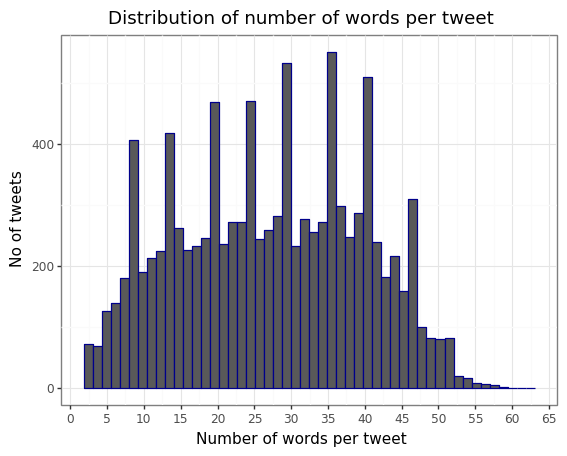

<ggplot: (100238539243)>

In [113]:
(
ggplot(data, aes(x="no_words"))+
geom_histogram(bins=50, color='darkblue')+
labs(x="Number of words per tweet", y="No of tweets", title="Distribution of number of words per tweet")+
theme_bw()+
scale_x_continuous(breaks=range(0,80,5))
)

In [114]:
data = data[data["no_words"]>2] #congratulations, great, good, 

In [115]:
Outliers = data[data["no_words"]<10][["text_stemmed"]].reset_index()
Outliers.drop("index",axis=1, inplace=True)
Outliers.to_csv('Ouliter_tweets.csv')

In [54]:
Outliers.head()

,text_stemmed
0,veri nice
1,kindli look into it pleas
2,haha final
3,congratul
4,congratul


## Choosing min_df

In [116]:
min_df=[]
vec_length=[]

for i in range(100):
    vectorizer = CountVectorizer(stop_words='english', min_df=i+1, binary=True)
    vectorizer.fit_transform(data["text_stemmed"])
    features=len(vectorizer.get_feature_names())
    vec_length.append(features)
    min_df.append(i+1)

C:\Users\hp\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.


In [96]:
plot=pd.DataFrame()
plot['min_df']=min_df
plot['vec_length']=vec_length

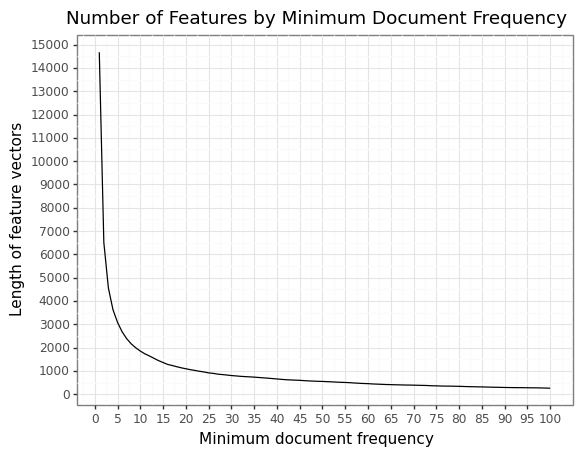

<ggplot: (133602783570)>

In [97]:
(ggplot(plot, aes(x=min_df, y=vec_length))+
geom_line()+
labs(x='Minimum document frequency', y='Length of feature vectors', title='Number of Features by Minimum Document Frequency')+
scale_x_continuous(breaks=range(0,101,5))+
scale_y_continuous(breaks=range(0,16000,1000))+
theme_bw()
)

In [117]:
# convert text to dtm with tfidf weighting
#norm l2 - sum of the squared elements equal to 1 
vect = TfidfVectorizer(stop_words='english', norm='l2',token_pattern="[^\W\d]+", min_df=50)
dtm = vect.fit_transform(data['text_stemmed'])
dtm.shape

(10488, 521)

In [267]:
dtm

<10488x521 sparse matrix of type '<class 'numpy.float64'>'
	with 95690 stored elements in Compressed Sparse Row format>

In [118]:
vect.vocabulary_

{'thi': 465,
 'like': 231,
 'worst': 515,
 'travel': 480,
 's': 388,
 'hour': 187,
 'sinc': 412,
 'm': 249,
 'station': 441,
 'nd': 278,
 'staff': 437,
 'arriv': 22,
 'just': 213,
 'expect': 143,
 'time': 471,
 'pleas': 324,
 'servic': 404,
 'railway': 350,
 'coach': 78,
 'posit': 330,
 'peopl': 315,
 'rush': 387,
 'special': 433,
 'pnr': 326,
 'abl': 0,
 'ani': 12,
 'charg': 67,
 'free': 160,
 'seat': 396,
 'near': 280,
 'got': 169,
 'ac': 1,
 'tt': 484,
 'didn': 119,
 'allow': 7,
 'kindli': 220,
 'sit': 415,
 'want': 507,
 'inform': 201,
 'run': 386,
 'delay': 111,
 'exam': 142,
 'varanasi': 501,
 'someth': 427,
 'express': 145,
 'water': 511,
 'work': 514,
 'rail': 348,
 'number': 294,
 'look': 240,
 'matter': 258,
 'late': 225,
 'irctc': 204,
 'wa': 505,
 'reach': 354,
 'know': 223,
 'dear': 108,
 'lot': 244,
 'reserv': 369,
 'enter': 138,
 'b': 31,
 'gener': 165,
 'request': 366,
 'stop': 444,
 'bed': 40,
 'provid': 340,
 'attend': 28,
 'use': 496,
 'bad': 32,
 'smell': 422,
 'cur

In [119]:
term_indices = {index: term for term, index in vect.vocabulary_.items()}
term_indices

{465: 'thi',
 231: 'like',
 515: 'worst',
 480: 'travel',
 388: 's',
 187: 'hour',
 412: 'sinc',
 249: 'm',
 441: 'station',
 278: 'nd',
 437: 'staff',
 22: 'arriv',
 213: 'just',
 143: 'expect',
 471: 'time',
 324: 'pleas',
 404: 'servic',
 350: 'railway',
 78: 'coach',
 330: 'posit',
 315: 'peopl',
 387: 'rush',
 433: 'special',
 326: 'pnr',
 0: 'abl',
 12: 'ani',
 67: 'charg',
 160: 'free',
 396: 'seat',
 280: 'near',
 169: 'got',
 1: 'ac',
 484: 'tt',
 119: 'didn',
 7: 'allow',
 220: 'kindli',
 415: 'sit',
 507: 'want',
 201: 'inform',
 386: 'run',
 111: 'delay',
 142: 'exam',
 501: 'varanasi',
 427: 'someth',
 145: 'express',
 511: 'water',
 514: 'work',
 348: 'rail',
 294: 'number',
 240: 'look',
 258: 'matter',
 225: 'late',
 204: 'irctc',
 505: 'wa',
 354: 'reach',
 223: 'know',
 108: 'dear',
 244: 'lot',
 369: 'reserv',
 138: 'enter',
 31: 'b',
 165: 'gener',
 366: 'request',
 444: 'stop',
 40: 'bed',
 340: 'provid',
 28: 'attend',
 496: 'use',
 32: 'bad',
 422: 'smell',
 102:

In [120]:
# create a list of column names from the term indices
colterms = [term_indices[i] for i in range(dtm.shape[1])] 

In [121]:
X = pd.DataFrame(dtm.toarray(), columns=colterms)

In [122]:
X

,abl,ac,action,actual,age,ahmedabad,allot,allow,alreadi,alway,...,water,way,whi,work,worst,wrong,ye,year,yesterday,yr
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.260999,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.317737,0.0,0.0,0.0,0.0,0.0
2,0.217973,0.152223,0.0,0.0,0.0,0.0,0.0,0.474642,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.370596,0.0,0.000000,0.36581,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10483,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
10484,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
10485,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0
10486,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0


In [123]:
vocab = vect.get_feature_names_out()

## Important features

In [124]:
tweets = list(data.text_stemmed)
vectorizer = CountVectorizer(stop_words='english', min_df=50, binary=True, token_pattern="[^\W\d]+")
bag_of_words = vectorizer.fit_transform(tweets)
sum_words = bag_of_words.sum(axis=0)

In [125]:
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)

words=[]
frequency=[]

for (x,y) in words_freq:
        words.append(x)
        frequency.append(y)
        
word_frequency = pd.DataFrame()
word_frequency['words'] = words
word_frequency['frequency'] = frequency

In [126]:
word_frequency['words'] = pd.Categorical(word_frequency.words, categories=pd.unique(word_frequency.words))

C:\Users\hp\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
C:\Users\hp\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars


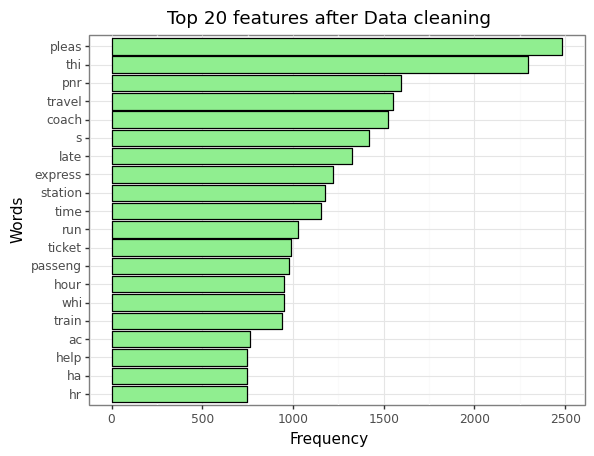

<ggplot: (100235112189)>

In [127]:
(ggplot(word_frequency[0:20],aes(x='reorder(words, frequency)', y='frequency'))+
 geom_bar(stat='identity', color='black', fill='lightgreen')+
 labs(y='Frequency', x='Words', title='Top 20 features after Data cleaning')+
 theme_bw()+
 coord_flip()
)

In [113]:
X.shape

(10488, 521)

# LDA - topic modelling

In [130]:
from sklearn.decomposition import LatentDirichletAllocation as LDA

#n_samples = 2000
n_topics = 12
n_top_words = 20

def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))

    print()

In [131]:
X.shape

(10488, 521)

In [133]:
# solution 1

n_samples = 10488
n_topics = 10
n_top_words = 20

print("Fitting LDA model with tf features, "
      "n_samples=%d and n_topics=%d..."
      % (n_samples, n_topics))

#define the lda function, with desired options
#Check the documentation, linked above, to look through the options
lda_new = LDA(n_components=n_topics, 
          max_iter=20,
          learning_method='online',
          learning_offset=80.,
          total_samples=n_samples,
              n_jobs=2,
          random_state=0)

#fit the model
lda_new.fit(X)
print("Done!")

print("\nTopics in LDA model:")
print_top_words(lda_new, vocab, n_top_words)

#Topic 0 - Train status
#Topic 1 - Staff
#Topic 2 - Railway exam and job
#Topic 3 - Delay
#Topic 4 - Blankets & Pillows
#Topic 5 - Cleanliness
#Topic 6 - Refunds
#Topic 7 - Reservations
#Topic 8 - Route
#Topic 9 - Others

Fitting LDA model with tf features, n_samples=10488 and n_topics=10...
Done!

Topics in LDA model:

Topic #0:
station line updat platform start jn pm time wa hr pleas th pune arriv statu departur nov today board mob

Topic #1:
p trn frm dt cl life v c end requir track basi live lost sr maintain nobodi anoth employe pnr

Topic #2:
result rrb inconveni clear ntpc level declar cen hai wait caus regret ka process ho nhi technician ke type sorri

Topic #3:
late run hour delay time hr whi thi train express reach min pleas stop reason minut s station stand passeng

Topic #4:
provid pnr bed blanket travel coach seat attend help b pleas pillow number ac berth bedsheet sheet linen demand express

Topic #5:
water clean coach toilet pleas dirti pnr veri s b travel washroom food condit rs express thi bad look station

Topic #6:
ticket book complaint action pleas refund ha thi share cancel ani close issu receiv repli taken contact resolv respons irctc

Topic #7:
coach ac seat travel s ticket peopl p

Topics in LDA model:

Topic #0: Train status
station line updat platform start jn pm time wa hr pleas th pune arriv statu departur nov today board mob

Topic #1: Staff
p trn frm dt cl life v c end requir track basi live lost sr maintain nobodi anoth employe pnr

Topic #2: Job/Exam results
result rrb inconveni clear ntpc level declar cen hai wait caus regret ka process ho nhi technician ke type sorri

Topic #3: Delay
late run hour delay time hr whi thi train express reach min pleas stop reason minut s station stand passeng

Topic #4:Blankets & Pillows
provid pnr bed blanket travel coach seat attend help b pleas pillow number ac berth bedsheet sheet linen demand express

Topic #5: Cleanliness
water clean coach toilet pleas dirti pnr veri s b travel washroom food condit rs express thi bad look station

Topic #6: Reservations & Refunds
ticket book complaint action pleas refund ha thi share cancel ani close issu receiv repli taken contact resolv respons irctc

Topic #7: Sleeper & General coaches
coach ac seat travel s ticket peopl passeng reserv class sleeper gener pleas express pnr thi work sit help compart

Topic #8: General maintainence
station thi problem work mumbai rout rail happen face pleas amp road local divis daili passeng need leav bag howrah

Topic #9: Others
railway indian india bharat thi servic whi vand onli year make student s shame come govern wrong state govt like

In [172]:
x = data[data['text_stemmed'].str.contains("servic")].reset_index()

In [173]:
x['text'][6]

' no one came to me nor contacted me but issue is closed why this issue is not resolved very bad service '

In [174]:
# Get the topic distribution array
topic_dist = lda_new.transform(X)

# Merge back in with the original dataframe
topic_dist_df = pd.DataFrame(topic_dist)
df_w_topics = topic_dist_df.join(data)

In [177]:
df_w_topics.columns = ['Train status','Staff','Job/Exam results','Delay', 'Blankets & Pillows', 'Cleanliness','Reservations & Refunds',                  'Sleeper & General coaches',                  'General maintainence',
                        'Others', 'Unnamed: 0','Unnamed: 0.1','text','created_at','tweet_id', 'user_id',        'user_name',    'user_location',
       'user_description',         'language',            'place',
        'sentiment_label',  'sentiment_score',        'locations',
             'first_name',      'gender_pred',     'text_stemmed',
               'no_words']

In [178]:
df_w_topics.head()

,Train status,Staff,Job/Exam results,Delay,Blankets & Pillows,Cleanliness,Reservations & Refunds,Sleeper & General coaches,General maintainence,Others,...,user_description,language,place,sentiment_label,sentiment_score,locations,first_name,gender_pred,text_stemmed,no_words
0,0.361789,0.021162,0.021163,0.021172,0.021165,0.021170,0.021166,0.468873,0.021166,0.021172,...,।। मेरा भारत महान ।। सामाजिक कार्यकर्ता \n🇮🇳 ...,NaN,NaN,NEGATIVE,0.999584,NaN,Secular,male,thi is like worst nightmar to travel via thi i...,39.0
1,0.159045,0.023608,0.023608,0.023617,0.023611,0.023614,0.023610,0.324787,0.023612,0.350889,...,NaN,NaN,NaN,NEGATIVE,0.999645,NaN,Jaswant,male,worst servic by northern railway no indic for ...,33.0
2,0.021593,0.021590,0.021590,0.021592,0.021594,0.021593,0.021604,0.805641,0.021598,0.021605,...,||MBBS👨‍⚕️||JSSMC||\nLove to Travel ✈️✈️||,NaN,NaN,NEGATIVE,0.994943,NaN,Gautam,male,pnr 4759117458 i am not abl to find ani charg ...,46.0
3,0.023471,0.023458,0.023468,0.788835,0.023463,0.023459,0.023464,0.023459,0.023462,0.023459,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.026442,0.026440,0.026443,0.026444,0.026445,0.762004,0.026444,0.026445,0.026452,0.026441,...,Eveything is possible,NaN,NaN,NEGATIVE,0.989721,NaN,Trilok,male,i want to inform you that no 05529 which is ru...,49.0


In [180]:
df_w_topics.to_csv('Final_topic_distribution_tweets.csv')

In [185]:
df_w_topics.shape

(10488, 28)

In [218]:
gender_topics = df_w_topics[['gender_pred','Train status','Staff','Job/Exam results','Delay', 'Blankets & Pillows', 'Cleanliness','Reservations & Refunds', 'Sleeper & General coaches', 'General maintainence',
                        'Others']].groupby('gender_pred').sum()

In [245]:
gender_dist = df_w_topics[df_w_topics['sentiment_label']=='NEGATIVE'].groupby('gender_pred').count().reset_index()

In [246]:
df_w_topics[df_w_topics['sentiment_label']=='NEGATIVE'].shape

(7215, 28)

In [247]:
gender_dist = gender_dist[['gender_pred','Unnamed: 0']]

In [248]:
gender_dist['Unnamed: 0'] = round(gender_dist['Unnamed: 0']*100/7215,1)

In [249]:
gender_dist

,gender_pred,Unnamed: 0
0,female,8.0
1,male,92.0


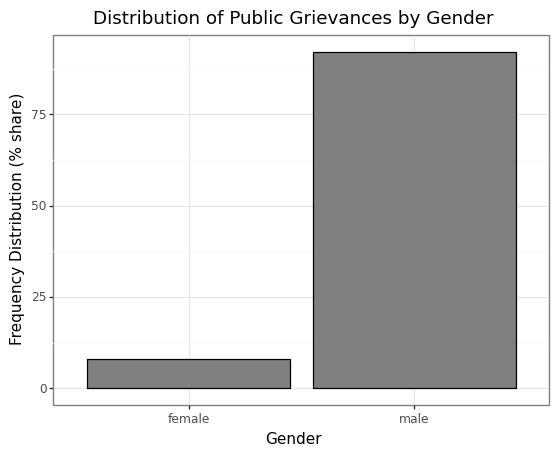

<ggplot: (100245553044)>

In [261]:
(ggplot(gender_dist,aes(x='gender_pred', y='Unnamed: 0'))+
 geom_bar(stat='identity', color='black', fill="grey")+
 labs(y='Frequency Distribution (% share)', x='Gender', title='Distribution of Public Grievances by Gender')+
 theme_bw()
)

In [231]:
set(df_w_topics.gender_pred == ""

{'female', 'male', nan}

In [227]:
gender_topics*100/10488

,Train status,Staff,Job/Exam results,Delay,Blankets & Pillows,Cleanliness,Reservations & Refunds,Sleeper & General coaches,General maintainence,Others
gender_pred,,,,,,,,,,
female,0.441820,0.260280,0.457299,0.887951,0.563265,0.566486,0.649242,0.792031,0.352073,0.512009
male,5.104678,2.925459,5.020782,10.283644,5.982805,7.553838,8.098228,8.243101,4.589584,5.508332


In [186]:
topic_dist = df_w_topics[['Train status','Staff','Job/Exam results','Delay', 'Blankets & Pillows', 'Cleanliness','Reservations & Refunds', 'Sleeper & General coaches', 'General maintainence',
                        'Others']].sum(axis=0)

In [189]:
topic_dist = pd.DataFrame(topic_dist)
topic_dist = topic_dist.reset_index()
topic_dist.columns = ['topic', '%share']

In [193]:
topic_dist['%share'] = topic_dist['%share']/10488

In [195]:
topic_dist['%share'] = round(topic_dist['%share']*100)

In [197]:
topic_dist = topic_dist.sort_values('%share', ascending=False)

In [202]:
topic_dist = topic_dist.reset_index()
topic_dist = topic_dist.drop('index',axis=1)

In [209]:
topic_dist.columns = ['topic', 'share']

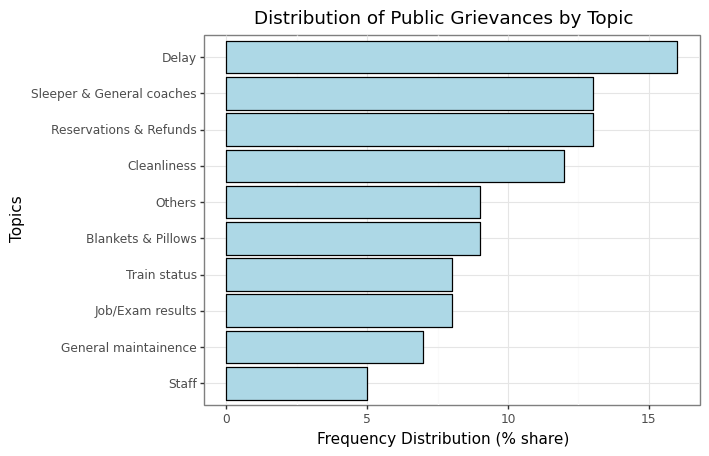

<ggplot: (100239269873)>

In [210]:
(ggplot(topic_dist,aes(x='reorder(topic,share)', y='share'))+
 geom_bar(stat='identity', color='black', fill='lightblue')+
 labs(y='Frequency Distribution (% share)', x='Topics', title='Distribution of Public Grievances by Topic')+
 theme_bw()+
 coord_flip()
)

In [ ]:
data[data['text_stemmed'].str.contains("servic")].reset_index()

In [122]:
df_w_topics[0].sum()

852.4491143685914

In [123]:
df_w_topics[1].sum()

482.32232569511086

In [124]:
df_w_topics[2].sum()

829.6869843196023

In [125]:
df_w_topics[3].sum()

1717.0183941725072

In [126]:
df_w_topics[4].sum()

988.4243493083163

In [127]:
df_w_topics[5].sum()

1227.0179672387148

In [128]:
df_w_topics[6].sum()

1330.832480826475

In [129]:
df_w_topics[7].sum()

1384.642340018254

In [130]:
df_w_topics[8].sum()

762.6525292577335

In [131]:
df_w_topics[9].sum()

912.953514794695

# K means clustering

In [268]:
labels = KMeans(init='k-means++', n_clusters=10, random_state=0, n_init=100).fit_predict(dtm)

# Validation

In [270]:
k_range = range(7,12)
inertia = []
silhouette = []

for i in k_range:
    km_i = KMeans(init='k-means++', n_clusters=i, max_iter=100000,
                  random_state=0, n_init=100)
    inertia.append(km_i.fit(dtm).inertia_)
    silhouette.append(silhouette_score(dtm, km_i.fit_predict(dtm), metric='euclidean'))